In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from fbprophet import Prophet
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from kneed import KneeLocator

In [2]:
def detect_outliers(dataframe, detect_method, replace_method=None, valid_fraction_interval=0.95, only_up=0, plot=False):
    '''
    Enter a time dataframe with the following columns: {ds: timeline ; y: values}
    Enter one of the following outliers detection methods: {prophet; svm; isoforest; gaussian; lof; kmeans}
    Enter one of the following outliers replace methods: {prophet; None; NaN; drop; last_observation_carried_forward;
                                                            next_observation_carried_backward; linear_interpolation;
                                                            mean; nearest_neighbor}
    Select only_up if you want just the upper outliers. Provide a value for the rolling mean which will serve as boundary.
    Enter the fraction expected of non-outliers or the width of prophet's confidence interval: [0,1]
    Decide whether or not to plot the outliers flagged in the series
    '''
    
    def normalize(data):
        scaler = StandardScaler()
        data = scaler.fit_transform(data)
        #data = pd.DataFrame(data)
        return data
    
    
    dataframe['ds']= pd.to_datetime(dataframe['ds'])
    outliers_fraction = 1-valid_fraction_interval
    
    
    # ********** Decect Outliers **********
    
    # PROPHET: either detect and/or replace
    if (detect_method == 'prophet') or (replace_method == 'prophet'):
        # fit the data
        model = Prophet(interval_width = valid_fraction_interval)
        model = model.fit(dataframe)
        df_anom = model.predict(dataframe)
        df_anom['y'] = dataframe['y'].reset_index(drop = True)
        
        if (detect_method == 'prophet'):
            print(f'Using Prophet to detect anomalies! Confidence interval of {(valid_fraction_interval*100):.2f} %.\n')
            # flag anomalies
            df_anom['anomaly'] = 0
            df_anom.loc[df_anom['y'] > df_anom['yhat_upper'], 'anomaly'] = 1
            df_anom.loc[df_anom['y'] < df_anom['yhat_lower'], 'anomaly'] = 1
        if (replace_method == 'prophet'):
            # keep predicted values
            prophet_yhat = df_anom['yhat'].to_frame()
    
    # ONE-CLASS SVM
    if (detect_method == 'svm'):
        print(f'Using a one-class SVM to detect anomalies! Outlier fraction of {(outliers_fraction*100):.2f} %.\n')
        
        df_anom = dataframe.copy()
        data = df_anom[['y']]
        data = normalize(data)

        # fit the data
        model = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01)
        model.fit(data)
        df_anom['anomaly'] = pd.Series(model.predict(data))

        # flag anomalies
        df_anom.loc[df_anom['anomaly'] == 1, 'anomaly'] = 0
        df_anom.loc[df_anom['anomaly'] == -1, 'anomaly'] = 1
    
    # ISOLATION FOREST
    elif (detect_method == 'isoforest'):
        print(f'Using an Isolation Forest to detect anomalies! Outlier fraction of {(outliers_fraction*100):.2f} %.\n')
        
        df_anom = dataframe.copy()
        data = df_anom[['y']]

        # fit the data
        model = IsolationForest(contamination=outliers_fraction)    # can be set to auto
        model.fit(data) 
        df_anom['anomaly'] = pd.Series(model.predict(data))

        # flag anomalies
        df_anom.loc[df_anom['anomaly'] == 1, 'anomaly'] = 0
        df_anom.loc[df_anom['anomaly'] == -1, 'anomaly'] = 1
    
    # GAUSSIAN DISTRIBUTION
    elif (detect_method == 'gaussian'):
        print(f'Using the Gaussian Distribution to detect anomalies! Outlier fraction of {(outliers_fraction*100):.2f} %.\n')
        
        df_anom = dataframe.copy()
        data = df_anom[['y']]
        
        # arrange the data
        data = data.values.reshape(-1,1)
        
        # fit the data
        model = EllipticEnvelope(contamination = outliers_fraction)
        model.fit(data)
        df_anom['deviation'] = model.decision_function(data)
        df_anom['anomaly'] = model.predict(data)

        # flag anomalies
        df_anom.loc[df_anom['anomaly'] == 1, 'anomaly'] = 0
        df_anom.loc[df_anom['anomaly'] == -1, 'anomaly'] = 1
        
    # LOCAL OUTLIER FACTION
    elif (detect_method == 'lof'):
        print(f'Using the Local Outlier Faction to detect anomalies! Outlier fraction of {(outliers_fraction*100):.2f} %.\n')
        
        # normalize the y column
        df_anom = dataframe.copy()
        data = df_anom[['y']]
        data = normalize(data)
        
        # fit the data
        model = LocalOutlierFactor(contamination=outliers_fraction)    # can be set to auto
        #model.fit_predict(data)
        df_anom['anomaly'] = pd.Series(model.fit_predict(data))

        # flag anomalies
        df_anom.loc[df_anom['anomaly'] == 1, 'anomaly'] = 0
        df_anom.loc[df_anom['anomaly'] == -1, 'anomaly'] = 1
    
    # KMEANS
    elif (detect_method == 'kmeans'):
        print(f'Using the K-Means to detect anomalies! Outlier fraction of {(outliers_fraction*100):.2f} %.\n')
        
        # normalize the data
        df_anom = dataframe.copy()
        data = df_anom[['y']]
        data = normalize(data)
        
        # detetar n_clus automaticamente
        sse = []
        for k in range(1, 11):
            km = KMeans(n_clusters=k)
            km.fit(data)
            sse.append(km.inertia_)
        kl = KneeLocator(range(1,11), sse, curve='convex', direction='decreasing')
        n_clus = kl.elbow
        print('n_cluster define by KneeLocator as',n_clus,'.')
        
        # fit the data
        model = KMeans(init='random', n_clusters=n_clus)
        model.fit(data)
        print('The lowest SSE value:',model.inertia_,'\n\nFinal locations of the centroid:',model.cluster_centers_,'\n\nThe number of iterations required to converge:',model.n_iter_)
        
        # find distance to center for each point
        distance = pd.Series()
        for i in range(0,len(data)):
            Xa = np.array(data[i])
            Xb = model.cluster_centers_[model.labels_[i]-1]
            distance.at[i] = np.linalg.norm(Xa-Xb)
        
        # flag anomalies
        n_outliers = int(outliers_fraction*len(distance))
        threshold = distance.nlargest(n_outliers).min()
        df_anom['anomaly'] = (distance >= threshold).astype(int)
        df_anom['k_label'] = model.labels_
        
        
    # ********** Select only up anomalies **********
    if only_up:
        df_anom['rollmean'] = df_anom['y'].rolling(only_up).mean()
        df_anom.loc[df_anom['rollmean'] > df_anom['y'], 'anomaly'] = 0
    
    
    # ********** Count the Number of Anomalies Flagged **********
    num_anom = np.count_nonzero(df_anom['anomaly'].to_numpy())
    print('A total of',num_anom,'anomalies were flagged!\n')
    
    
    # ********** Visualize the Results **********
    if plot:
        fig, ax = plt.subplots(figsize=(10,6))
        a = dataframe.loc[df_anom['anomaly'] == 1, ['ds', 'y']] #anomaly

        ax.plot(df_anom['ds'], df_anom['y'], color='blue')
        ax.scatter(a['ds'],a['y'], color='red')
        if only_up:
            ax.plot(df_anom['ds'],df_anom['rollmean'], color='yellow')
        plt.show();
    

    # ********** Replace Outliers with... **********
    
    # ... do nothing
    if (replace_method == None) or (replace_method) == 'None':
        return df_anom
    
    # create new column for the new values of y without outliers
    df_anom['new_y'] = df_anom['y']
    df_anom.loc[df_anom['anomaly'] == 1, 'new_y'] = np.nan
    
    # ... NaN
    if (replace_method == 'NaN'):
        return df_anom
    
    #... dropping out the outliers
    if (replace_method == 'drop'):
        df_anom = df_anom.dropna(subset=['new_y'])
        df_anom = df_anom.drop(columns=['new_y'])
        print("Rows with outlier values were dropped!")
        return df_anom
    
    #... Prophet predicted values
    elif (replace_method == 'prophet'):
        df_anom.loc[df_anom['anomaly'] != 0, 'new_y'] = prophet_yhat['yhat']
    
    # ... last observation carried forward
    elif (replace_method == 'last_observation_carried_forward'):
        df_anom['new_y'].fillna(method='ffill', inplace=True)
    
    # ... next observation carried backward
    elif (replace_method == 'next_observation_carried_backward'):
        df_anom['new_y'].fillna(method='bfill', inplace=True)
    
    # ... Linear interpolation
    elif (replace_method == 'linear_interpolation'):
        df_anom['new_y'].interpolate(method='linear', inplace=True)
    
    # ... signal mean
    elif (replace_method == 'mean'):
        df_anom['new_y'].fillna(df_anom['new_y'].mean(), inplace=True)
    
    # ... nearest neighbor
    elif (replace_method == 'nearest_neighbor'):
        df_anom['new_y'].interpolate(method='nearest', inplace=True)
    
    print("Outliers replaced using",replace_method,"method. Please remember to check the boundaries of the dataframe!")
        
    
    return df_anom

In [3]:
def fit_predict_model(dataframe, interval_width = 0.95, changepoint_range = 0.8):
    #m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
    #            seasonality_mode = 'multiplicative', 
    #            interval_width = interval_width,
    #            changepoint_range = changepoint_range)
    
    m = Prophet(interval_width = interval_width)
    m = m.fit(dataframe)
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    
    fig = m.plot(forecast)
    
    return forecast

# Run code

Sales:


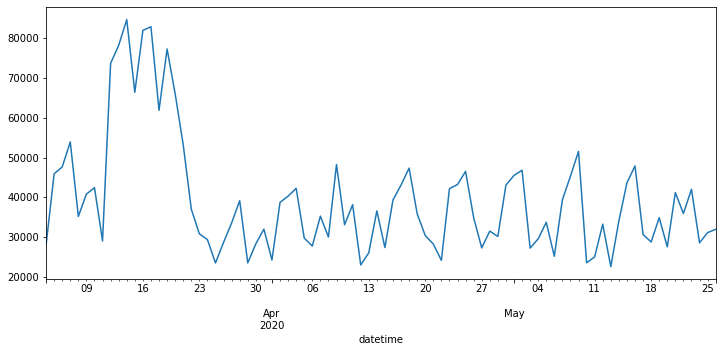

In [4]:
df = pd.read_csv('sliced_30minstore274.csv', sep=',', parse_dates=True, index_col='datetime')
df = df.resample('D').sum()
print("Sales:")
df['sales'].plot(figsize=(12,5))
df = df.reset_index()
df = df[['datetime','sales']]
df = df.rename(columns={'datetime':'ds','sales':'y'})

## Prophet's uncertainty interval

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


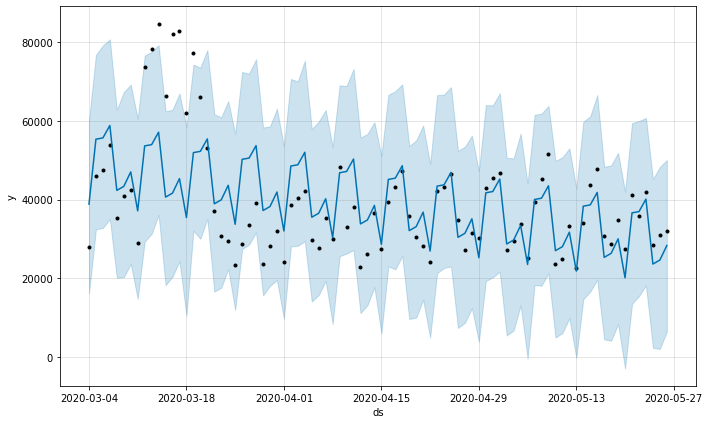

In [5]:
pred = fit_predict_model(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Using Prophet to detect anomalies! Confidence interval of 95.00 %.

A total of 7 anomalies were flagged!



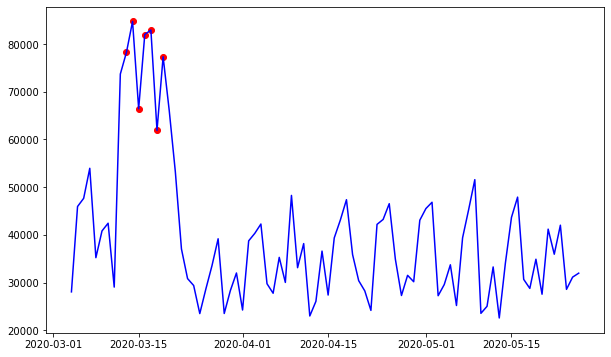

Outliers replaced using prophet method. Please remember to check the boundaries of the dataframe!


In [6]:
df_o = detect_outliers(df[['ds','y']], detect_method='prophet', replace_method='prophet', valid_fraction_interval=0.95, plot=True) #, only_up=(7))
df_o = df_o[['ds','yhat_lower','yhat_upper','yhat','y','new_y','anomaly']]

In [7]:
df_o.loc[df_o['anomaly'] == 1]

,ds,yhat_lower,yhat_upper,yhat,y,new_y,anomaly
9,2020-03-13,31721.964013,75885.082509,53982.602490,78239,53982.602490,1
10,2020-03-14,35829.493301,78140.770590,57146.546435,84714,57146.546435,1
11,2020-03-15,17385.226591,61762.309778,40655.968120,66436,40655.968120,1
12,2020-03-16,19055.860984,64262.768163,41671.170322,81983,41671.170322,1
13,2020-03-17,24025.027968,68036.090703,45356.885440,82912,45356.885440,1
14,2020-03-18,13260.437711,58384.385909,35458.796601,61898,35458.796601,1
15,2020-03-19,30719.190575,74480.314993,51957.315595,77319,51957.315595,1


<AxesSubplot:xlabel='ds'>

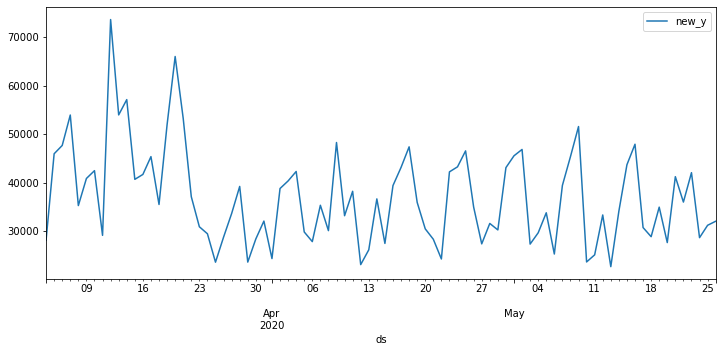

In [8]:
df_o[['ds','new_y']].set_index('ds').plot(figsize=(12,5))

## Sklearn classification methods

Using a one-class SVM to detect anomalies! Outlier fraction of 10.00 %.

A total of 4 anomalies were flagged!



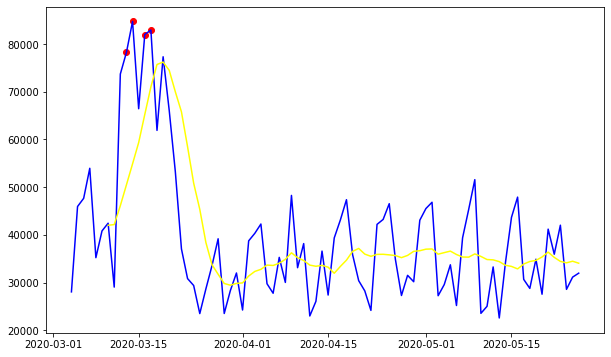

,ds,y,anomaly
9,2020-03-13,78239,1
10,2020-03-14,84714,1
12,2020-03-16,81983,1
13,2020-03-17,82912,1


In [9]:
df_o = detect_outliers(df[['ds','y']], detect_method='svm', replace_method=None, valid_fraction_interval=0.90, plot=True, only_up=(7))
df_o.drop(columns='rollmean', inplace=True)
df_o.loc[df_o['anomaly'] == 1]

### Get the residual component

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<AxesSubplot:xlabel='ds'>

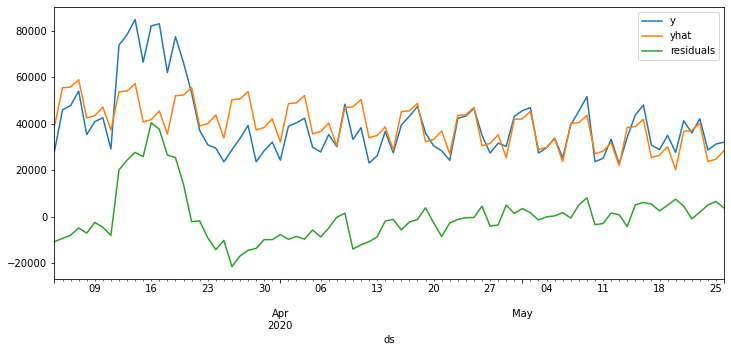

In [10]:
# run to remove trend and seasonality from the TS
df['ds']= pd.to_datetime(df['ds'])
m = Prophet()
m.fit(df)
forecast = m.predict()
forecast = pd.merge(df, forecast, on='ds')
forecast['residuals'] = forecast['y'] - forecast['yhat']
forecast = forecast[['ds','y','yhat','residuals']]
forecast[['ds','y','yhat','residuals']].set_index(['ds']).plot(figsize=(12,5))

<ipython-input-2-a942d01a96bb>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['ds']= pd.to_datetime(dataframe['ds'])


Using a one-class SVM to detect anomalies! Outlier fraction of 10.00 %.

A total of 3 anomalies were flagged!



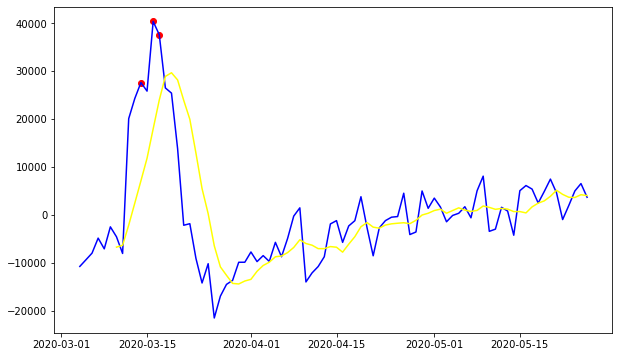

,ds,residuals,y,anomaly
10,2020-03-14,27567.453565,84714,1
12,2020-03-16,40311.829678,81983,1
13,2020-03-17,37555.114560,82912,1


In [11]:
forecast = forecast.rename(columns={'y':'real_y','residuals':'y'})
df_o = detect_outliers(forecast[['ds','y','real_y']], detect_method='svm', replace_method=None, valid_fraction_interval=0.90, plot=True, only_up=(7))
df_o.drop(columns='rollmean', inplace=True)

df_o = df_o.rename(columns={'y':'residuals','real_y':'y'})
df_o.loc[df_o['anomaly'] == 1]